# Computing the generalization bound

In [1]:
import os

import pennylane as qml

import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

import numpy as np

## Useful functions

In [3]:
def create_circuit(n_qubits, layers, p=0.0, noise_type="depolarizing"):
    noise_gate = qml.DepolarizingChannel
    if noise_type == "depolarizing":
        noise_gate = qml.DepolarizingChannel
    elif noise_type == "phase_damp":
        noise_gate = qml.PhaseDamping
    elif noise_type == "ampl_damp":
        noise_gate = qml.AmplitudeDamping
    elif noise_type == "gen_ampl_damp":
        noise_gate = qml.GeneralizedAmplitudeDamping

    if p == 0.0:
        key = jax.random.PRNGKey(12345)
        device = qml.device(
            "default.qubit.jax",
            wires=n_qubits,
        )
    else:
        dev_ideal = qml.device("default.mixed", wires=n_qubits)
        # apply noise to device
        device = qml.transforms.insert(noise_gate, p, position="all")(dev_ideal)

    def embedding(x, layer, wires):
        # assert len(x)==1
        for i, wire in enumerate(wires):
            qml.RY((x[i % len(x)]), wires=wire)
        for i, wire in enumerate(wires):
            qml.RZ((x[i % len(x)] ** 2), wires=wire)

    def var_ansatz(
        theta,
        wires,
        rotations=[qml.RX, qml.RZ, qml.RX],
        entangler=qml.CNOT,
    ):
        # the length of `rotations` defines the number of inner layers
        N = len(wires)
        assert len(theta) == 3 * N
        wires = list(wires)

        # each inner layer can have a different rotation
        for in_lay, rot in enumerate(rotations):
            angles = theta[in_lay * N : (in_lay + 1) * N]

            for i, angle in enumerate(angles):
                rot(angle, wires=wires[i % N])
            for qb in wires[:-1]:
                entangler(wires=[wires[qb], wires[qb + 1]])

    @qml.qnode(device, interface="jax")
    def circuit(
        x,
        theta,
    ):
        # print(x)
        # print(theta)

        for i in range(layers):
            embedding(x, layer=i + 1, wires=range(n_qubits))
            qml.Barrier(only_visual=True)
            var_ansatz(
                theta[i * params_per_layer : (i + 1) * params_per_layer],
                wires=range(n_qubits),
                entangler=qml.CNOT,
            )
            qml.Barrier(only_visual=True)

        return qml.expval(qml.PauliZ(wires=0))  # we measure only the first qubit

    return circuit


def create_circuit_diabetes(n_qubits, layers, p=0.0, noise_type="depolarizing"):
    noise_gate = qml.DepolarizingChannel
    if noise_type == "depolarizing":
        noise_gate = qml.DepolarizingChannel
    elif noise_type == "phase_damp":
        noise_gate = qml.PhaseDamping
    elif noise_type == "ampl_damp":
        noise_gate = qml.AmplitudeDamping
    elif noise_type == "gen_ampl_damp":
        noise_gate = qml.GeneralizedAmplitudeDamping

    if p == 0.0:
        key = jax.random.PRNGKey(12345)
        device = qml.device(
            "default.qubit.jax",
            wires=n_qubits,
        )  # shots=8192, prng_key=key
    else:
        dev_ideal = qml.device("default.mixed", wires=n_qubits)
        # apply noise to device
        device = qml.transforms.insert(noise_gate, p, position="all")(dev_ideal)

    def embedding(x, layer, wires):
        qml.RX((x[0]), wires=wires[0])
        qml.RX((x[1]), wires=wires[2])
        qml.Barrier(only_visual=True)

    def var_ansatz(
        theta,
        wires,
    ):
        # the length of `rotations` defines the number of inner layers
        N = len(wires)
        wires = list(wires)

        for i, wire in enumerate(wires):
            qml.RY(theta[i], wires=wire)

        for i, wire in enumerate(wires):
            qml.IsingXX(theta[N + i], wires=[i, (i + 1) % N])

    @qml.qnode(device, interface="jax")
    def circuit(
        x,
        theta,
    ):
        for i in range(layers):
            embedding(x, layer=i + 1, wires=range(n_qubits))

            var_ansatz(
                theta[i * params_per_layer : (i + 1) * params_per_layer],
                wires=range(n_qubits),
            )

        return qml.expval(
            qml.PauliZ(wires=[0])
            @ qml.PauliZ(wires=[1])
            @ qml.PauliZ(wires=[2])
            @ qml.PauliZ(wires=[3])
        )  # we measure only the first qubit

    return circuit

Choosing the dataset

In [5]:
from datasets import *

dataset = "sin"

if dataset == "sin":
    X, X_test, y, y_test = make_sin_dataset(dataset_size=50, test_size=0.7)

elif dataset == "sin2":
    X, X_test, y, y_test = make_sin_dataset(dataset_size=20, test_size=0.25)

elif dataset in ["diabetes", "diabetes2"]:
    X = make_diabetes_dataset(dataset)

elif dataset == "random":
    np.random.seed(690)
    if design == "paper_model":
        X = np.random.normal(0, 1, size=(15, 2))
    if design == "2design":
        X = np.random.normal(0, 1, size=(15, 1))

elif dataset == "uniform":
    np.random.seed(690)
    if design == "paper_model":
        X = np.random.uniform(-np.pi, np.pi, size=(15, 2))
    if design == "2design":
        X = np.random.uniform(-np.pi, np.pi, size=(15, 1))

print(X)

[[ 0.87755102]
 [ 0.30612245]
 [-0.63265306]
 [ 0.95918367]
 [ 0.71428571]
 [-0.59183673]
 [ 0.26530612]
 [-0.2244898 ]
 [ 0.91836735]
 [-0.51020408]
 [-0.95918367]
 [ 0.51020408]
 [-0.71428571]
 [ 0.10204082]
 [-0.75510204]]


### computing Lipschitz consts

In [ ]:
## we estimate the Lipschitz constant with the max norm of random gradients
## over the same params we used for computing the average qfim


design = "paper_model"  #'2design'#
dataset = "sin"

layers = 3
noise_standard = (
    np.array(
        [
            0,
            1e-5,
            1e-3,
            5e-3,
            1e-2,
            2e-2,
            3e-2,
            4e-2,
            5e-2,
            6e-2,
            7e-2,
            8e-2,
            9e-2,
            1e-1,
            2e-1,
            4e-1,
            7e-1,
        ]
    )
    * 1e-1
)
if design == "paper_model":
    noise_standard = np.concatenate(
        [noise_standard, [10**i for i in np.linspace(-3, 0, 13)]]
    )
    noise_standard = np.concatenate([noise_standard, np.array([3, 5, 8, 9]) * 1e-2])
print(sorted(noise_standard))

for noise_type in ["depolarizing", "phase_damp", "ampl_damp"]:  #
    print(noise_type)
    dir_path = "."  # os.path.dirname(absolute_path)
    data_folder = (
        dir_path + f"/data/NIE/{dataset}/{design}/{noise_type}/{layers}_layers"
    )
    os.makedirs(data_folder, 0o755, exist_ok=True)
    try:
        lipschitz_dict = np.load(
            data_folder + f"/lipschitz_const.npy", allow_pickle=True
        )[()]
    except:
        lipschitz_dict = {}

    for p in sorted(noise_standard[1:]):
        seed = 12345
        norms = []

        if design == "2design":
            n_qubits = 5
            inner_layers = 3
            qnn = create_circuit(n_qubits, layers, p, noise_type)

        elif design == "paper_model":
            n_qubits = 4
            inner_layers = 2
            qnn = create_circuit_diabetes(n_qubits, layers, noise_type=noise_type, p=p)

        jacob_f = jax.jit(
            jax.jacrev(
                qnn,
                argnums=1,
            )
        )

        for i, x in enumerate(X):
            print(f"Sample {i:3}/{len(X)}", end="\r")

            key = jax.random.PRNGKey(seed)

            # averaging over 5 different param vectors
            for _ in range(5):
                key = jax.random.split(key)[0]
                params_per_layer = inner_layers * n_qubits

                random_params = jax.random.normal(
                    key, shape=(layers * params_per_layer,)
                )

                jacob = jacob_f(
                    x,
                    random_params,
                )

                jac_norm = jnp.linalg.norm(jacob)
                norms.append(jac_norm)

        L = jnp.max(jnp.array(norms))
        lipschitz_dict[p] = norms

        print(
            f"p:{p:.5f},max: {L:.5f}, mean: {jnp.mean(jnp.array(norms)):.5f},std: {jnp.std(jnp.array(norms)):.5f}"
        )
        np.save(data_folder + f"/lipschitz_const.npy", lipschitz_dict)
    print()

## Noise effect on gen. bound

In [16]:
from scipy.special import gamma
from jax.scipy.linalg import eigh
import sys

eps = sys.float_info.epsilon  # numerical precision for floats

gamma_f = gamma

design = "paper_model"
dataset = "sin"
noise_type = "depolarizing"
noise_standard = (
    np.array(
        [
            0,
            1e-5,
            1e-3,
            5e-3,
            1e-2,
            2e-2,
            3e-2,
            4e-2,
            5e-2,
            6e-2,
            7e-2,
            8e-2,
            9e-2,
            1e-1,
            2e-1,
            4e-1,
            7e-1,
        ]
    )
    * 1e-1
)
if design == "2design":
    n_qubits = 5
    noise_values = noise_standard[1:]
elif design == "paper_model":
    n_qubits = 4
    noise_standard = np.concatenate(
        [noise_standard, [10**i for i in np.linspace(-3, 0, 13)]]
    )
    noise_values = sorted(list(noise_standard[2:]))


layers = 5
dir_path = "."  # os.path.dirname(absolute_path)
data_folder = dir_path + f"/data/NIE/{dataset}/{design}/{noise_type}/{layers}_layers"


lipschitz_dict = np.load(data_folder + f"/lipschitz_const.npy", allow_pickle=True)[()]


##### new approach, single values and then mean

# creating a dictionary with single qfims eigenvalues
det_dict = {}
rank_dict = {}
for p in noise_values:
    qfims = np.load(
        data_folder + f"/QFIMs/{dataset}_QFIMs_noisy_{p}.npy", allow_pickle=True
    )[()][p]
    w_s = list(map(lambda x: eigh(x)[0], qfims))
    rank_dict[p] = list(
        map(lambda w: len(list(filter(lambda x: x > eps * np.shape(w)[0], w))), w_s)
    )
    det_dict[p] = np.prod(w_s, axis=1, dtype=np.float64)

### Computing $B(p)$ from QFIMs

In [17]:
gaps = []
gaps_std = []
gaps_array_list = []

determinants = []
determinants_std = []

lipschitz = []
gradients = []
d_list = []
d_list_std = []
for p in sorted(noise_values):
    L = np.array(np.max(lipschitz_dict[p]))
    grads = np.array(lipschitz_dict[p])
    d = np.array(rank_dict[p])
    det = np.where(det_dict[p] == 0.0, np.nan, det_dict[p])

    gaps_array = np.sqrt(d) * (gamma_f(d / 2 + 1) / np.sqrt(det)) ** (1 / d) * L
    gaps_array_list.append(gaps_array)

    determinants.append(np.nanmean(np.sqrt(det)))
    determinants_std.append(np.nanstd(np.sqrt(det)))
    lipschitz.append(L)
    gradients.append(grads)
    d_list.append(np.nanmean(d))
    d_list_std.append(np.nanstd(d))
    gaps.append(np.nanmean(gaps_array))
    gaps_std.append(np.nanstd(gaps_array))

gaps = np.array(gaps)
gaps_std = np.array(gaps_std)

determinants = np.array(determinants)
determinants_std = np.array(determinants_std)

d_list = np.array(d_list)
d_list_std = np.array(d_list_std)


opt_p_array = []
for g in np.array(gaps_array_list).T:
    try:
        opt_p_array.append(noise_values[np.nanargmin(g)])
    except ValueError:
        opt_p_array.append(np.nan)
# opt_p_array = noise_values[np.nanargmin(gaps_array_list, axis=0)]

opt_p = np.nanmean(opt_p_array)
opt_p_std = np.nanstd(opt_p_array)

print(noise_type)
print(rf"p* from B(p): {opt_p:.4f} ± {opt_p_std:.4f}")

depolarizing
p* from B(p): 0.1778 ± 0.0000


/var/folders/5r/15r_k83j1nvc0gf3vbrtfsl00000gq/T/ipykernel_88259/2911065477.py:21: RuntimeWarning: Mean of empty slice
  determinants.append(np.nanmean(np.sqrt(det)))
/var/folders/5r/15r_k83j1nvc0gf3vbrtfsl00000gq/T/ipykernel_88259/2911065477.py:27: RuntimeWarning: Mean of empty slice
  gaps.append(np.nanmean(gaps_array))
/var/folders/5r/15r_k83j1nvc0gf3vbrtfsl00000gq/T/ipykernel_88259/2911065477.py:18: RuntimeWarning: divide by zero encountered in divide
  gaps_array = np.sqrt(d)*(gamma_f(d/2+1)/np.sqrt(det))**(1/d)*L


## Plot

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation
from matplotlib import cm
import seaborn as sns

sns.set(font_scale=1.5)
sns.set_style("ticks")
mpl.pyplot.rc("text", usetex=True)
mpl.pyplot.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": "Computer Modern",
        "text.latex.preamble": r"\usepackage{amsfonts}",
    }
)

from matplotlib import rcParams

rcParams["lines.linewidth"] = 3

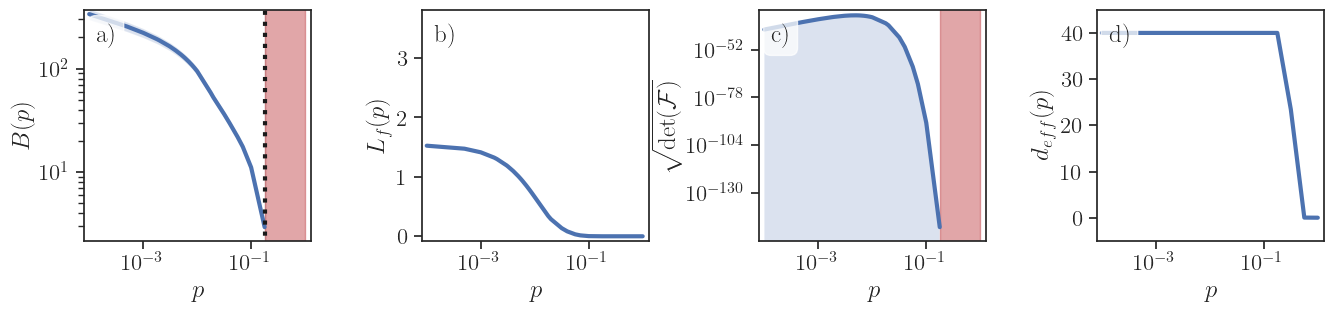

In [ ]:
# import matplotlib
from matplotlib.ticker import LogLocator


if noise_type == "depolarizing":
    labels = ["a)", "b)", "c)", "d)"]
elif noise_type == "phase_damp":
    labels = ["e)", "f)", "g)", "h)"]
elif noise_type == "ampl_damp":
    labels = ["i)", "j)", "k)", "l)"]

# if dataset == 'sin':
#     data = 'Sinusoidal'
# if dataset == 'diabetes':
#     data = 'Diabetes'

fig, ax = plt.subplots(1, 4, figsize=(16, 3))

### array of unacceptable values -- > no bound
nan_idxs = np.where(np.isnan(gaps))[0]
# nan_idxs = np.union1d(nan_idxs,np.where(np.array(determinants)==0.)[0])
##############################################
# fig.suptitle(f'{data} - {layers} layers')

ax[0].plot(noise_values, gaps)
ax[0].fill_between(
    noise_values,
    gaps - gaps_std,
    gaps + gaps_std,
    alpha=0.2,
)

ax[0].vlines(opt_p, -0.02, np.nanmax(gaps) * 1.1, linestyle="dotted", color="k")
ax[0].fill_betweenx(
    [-0.02, np.nanmax(gaps) * 1.1],
    opt_p - opt_p_std,
    opt_p + opt_p_std,
    color="k",
    alpha=0.2,
)

ax[0].set_ylabel(r"$B(p)$")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
if np.nanmax(gaps) / np.nanmin(gaps) < 1e2:
    ax[0].yaxis.set_major_locator(
        LogLocator(
            10,
        )
    )
    ax[0].yaxis.set_minor_locator(
        LogLocator(10, subs=(0.2, 0.4, 0.6, 0.8), numticks=12)
    )
    ax[0].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax[0].set_ylim(top=np.nanmax(gaps) * 1.1)

ax[1].plot(noise_values, lipschitz)
# ax[1].plot(noise_values, np.mean(gradients, axis=1), label=r'mean $\nabla f$')
# ax[1].fill_between(noise_values, np.mean(gradients, axis=1)-np.std(gradients, axis=1),
#                    np.mean(gradients, axis=1)+np.std(gradients, axis=1), alpha=0.3)
ax[1].set_ylabel(r"$L_f(p)$")
# ax[1].set_yscale('log')
if np.nanmax(lipschitz) / np.nanmin(lipschitz) < 1e2:
    ax[1].yaxis.set_major_locator(
        LogLocator(
            10,
        )
    )
    ax[1].yaxis.set_minor_locator(
        LogLocator(10, subs=(0.2, 0.4, 0.6, 0.8), numticks=12)
    )
    ax[1].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax[1].set_xscale("log")
ax[1].set_ylim(
    top=np.nanmax(lipschitz) * 2.5
)  # +np.nanmax(lipschitz)/np.nanmin(lipschitz))
# ax[1].legend()


ax[2].plot(noise_values, determinants)  # np.sqrt(
ax[2].fill_between(
    noise_values,
    determinants - determinants_std,
    determinants + determinants_std,
    alpha=0.2,
)

if nan_idxs.shape[0] != 0:
    start = nan_idxs[0]
    for i, idx in enumerate(nan_idxs[:-1]):
        if idx + 1 != nan_idxs[i + 1]:
            end = i + 1
            ax[0].fill_betweenx(
                [0.0, 1e50],
                [noise_values[start] * 0.8],
                [noise_values[end]],
                alpha=0.5,
                color="r",
            )
            ax[2].fill_betweenx(
                [0.0, 1],
                [noise_values[start] * 0.8],
                [noise_values[end]],
                alpha=0.5,
                color="r",
            )
            start = nan_idxs[i + 1] - 1

        if i + 1 == np.shape(nan_idxs)[0] - 1:
            if start == nan_idxs[0]:
                start -= 1
            end = nan_idxs[i + 1]
            ax[0].fill_betweenx(
                [0.0, 1e50], [noise_values[start]], [1], alpha=0.5, color="r"
            )
            ax[2].fill_betweenx(
                [0.0, 1], [noise_values[start]], [1], alpha=0.5, color="r"
            )


ax[2].set_ylabel(r"$\sqrt{\det(\mathcal{F})}$")
ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[2].set_ylim(top=np.nanmax(determinants) * 1e3)  # np.sqrt()

ax[3].plot(noise_values, d_list)
ax[3].fill_between(
    noise_values,
    d_list - d_list_std,
    d_list + d_list_std,
    alpha=0.2,
)

ax[3].set_ylabel(r"$d_{eff}(p)$")
ax[3].set_xscale("log")
# ax[3].set_yscale('log')
if np.nanmax(d_list) / np.nanmin(d_list) < 1e2:
    ax[3].set_ylim(
        top=np.nanmax(d_list) + np.nanmax(d_list) / np.nanmin(d_list),
        bottom=np.nanmin(d_list) - np.nanmax(d_list) / np.nanmin(d_list),
    )
else:
    ax[3].set_ylim(top=np.nanmax(d_list) + 5, bottom=np.nanmin(d_list) - 5)


for a in ax.flatten():
    if design == "2design":
        a.set_xlim(noise_values[0] * 0.8, 0.13)
    elif design == "paper_model":
        a.set_xlim(noise_values[0] * 0.8, 1.3)
    a.set_xlabel(r"$p$")

for p, a in enumerate(ax.flatten()):
    props = dict(boxstyle="round", facecolor="white", alpha=0.75)
    a.text(
        0.175,
        0.775,
        labels[p],
        transform=(
            a.transAxes + ScaledTranslation(-20 / 72, +10 / 72, fig.dpi_scale_trans)
        ),
        weight="bold",
        # fontsize='medium',
        va="bottom",
        # fontfamily='serif'
        backgroundcolor="white",
        bbox=props,
    )

plt.subplots_adjust(wspace=0.485)
plot_folder = f"./plots/NIE/{dataset}/{design}/{noise_type}"
os.makedirs(plot_folder, 0o755, exist_ok=True)
fig.savefig(
    plot_folder + f"/{dataset}_{layers}_{noise_type}_generalization_bound.pdf",
    bbox_inches="tight",  # pad_inches=.75
)